In [1]:
from __future__ import print_function
import argparse
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
from datasets import PartDataset
import torch.nn.functional as F
import torch.cuda as cuda
from pic2points_model import pic2points
from torch.nn.parallel import DataParallel
from torch.autograd import Variable
import torch
from data_loader import XDataset, get_loader
from split_data import read_from_file, write_to_file, split_data
import time
from visualize import Visualize
from chamfer_distance import ChamferDistance

In [11]:
type_image = 'bed'
shuffle_test = False


# Decide on GPU or CPU
if torch.cuda.is_available():
    gpu_or_cpu = torch.device('cuda')
else:
    gpu_or_cpu = torch.device('cpu')

image_root = "/datasets/cs253-wi20-public/ShapeNetRendering/"
point_cloud_root = "/datasets/cs253-wi20-public/ShapeNet_pointclouds/"

num_epochs = 20
batch_size = 64
shuffle = True
num_workers = 8
use_2048 = True
img_size = 227 # I don't know why, but this has to be 227!
learning_rate = 5e-4
num_points = 2500
transform = transforms.Compose([transforms.Resize(img_size,interpolation=2),
                                transforms.CenterCrop(img_size),transforms.ToTensor()])



path_train = 'train_data.txt'
path_val = 'val_data.txt'
path_test = 'test_data.txt'

train_data = read_from_file(path_train)
val_data = read_from_file(path_val)
test_data = read_from_file(path_test)


# Data loader
train_data_loader = get_loader(image_root, point_cloud_root, train_data, use_2048, 
                         transform, batch_size, shuffle, num_workers)

val_data_loader = get_loader(image_root, point_cloud_root, val_data, use_2048, 
                         transform, batch_size, shuffle, num_workers)
test_data_loader = get_loader(image_root, point_cloud_root, test_data, use_2048, 
                         transform, batch_size, shuffle, num_workers)



# model = torch.load('best-Baseline_DL_Vis_5000.pt', map_location=torch.device('cpu'))
model = torch.load('best-Baseline_DL_Vis_5000.pt')
model = model.cuda()
model.eval()

print('Loaded model')

Loaded model


Shape is

(5000, 3)
Shape is

(5000, 3)
Shape is

(5000, 3)
Shape is

(5000, 3)
Shape is

(5000, 3)
Shape is

(5000, 3)


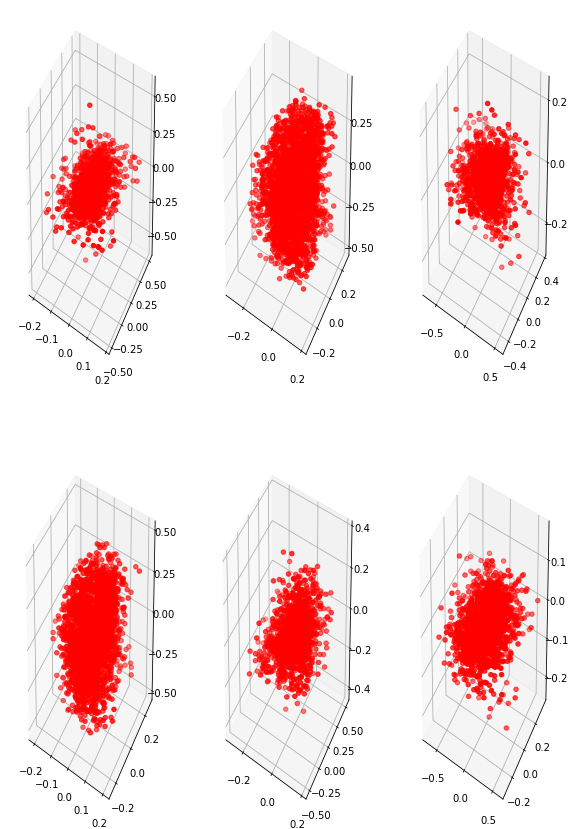

In [12]:
for i, (image, point_cloud) in enumerate(train_data_loader):
    image, point_cloud= image.to(device=gpu_or_cpu), point_cloud.to(device=gpu_or_cpu)
    image, point_cloud = Variable(image, requires_grad = False), Variable(point_cloud, requires_grad = False)

    image, point_cloud = image.float().to(device=gpu_or_cpu), point_cloud.float().to(device=gpu_or_cpu)
    pred = model(image)
#     dist1, dist2 = chamferDist(pred, point_cloud)
#     loss = (torch.mean(dist1)) + (torch.mean(dist2))

#     print('pred size = ', pred.size())
    pred = pred.to('cpu')
    

    out = []

    for p in pred:
        out.append(p.detach().numpy())

    Visualize(out).ShowRandom()
    
    break

Shape is

(2048, 3)
Shape is

(2048, 3)
Shape is

(2048, 3)
Shape is

(2048, 3)
Shape is

(2048, 3)
Shape is

(2048, 3)


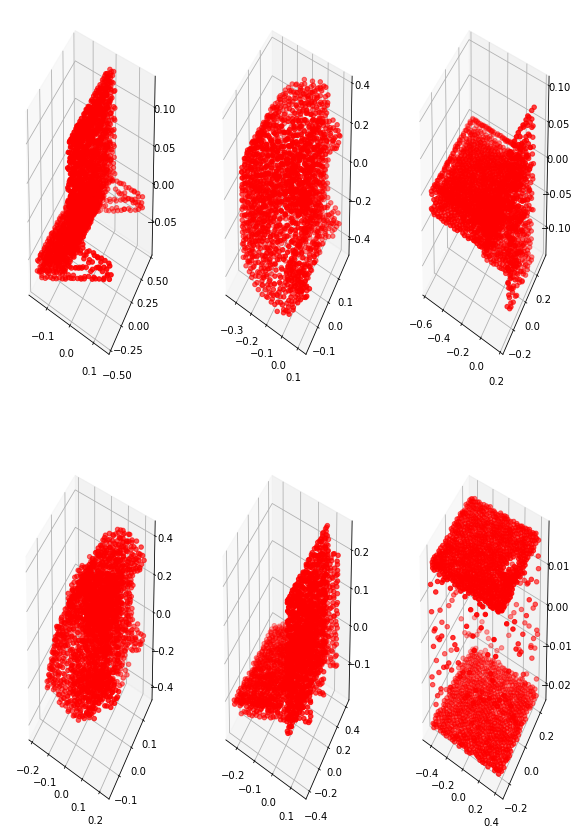

In [13]:
point_cloud = point_cloud.to('cpu')

out_p = []

for p in point_cloud:
    out_p.append(p.detach().numpy())
Visualize(out_p).ShowRandom()

In [15]:
# Compute the chamfer distance and hausdorff distance


chamferDist = ChamferDistance()

total_train_loss = 0.
# Get loss on training data.
with torch.no_grad():
    for i, (image, point_cloud) in enumerate(train_data_loader):

        image, point_cloud = Variable(image), Variable(point_cloud)

        image, point_cloud = image.float().to(device=gpu_or_cpu), point_cloud.float().to(device=gpu_or_cpu)
        pred = model(image)
        dist1, dist2 = chamferDist(pred, point_cloud)
        loss = (torch.mean(dist1)) + (torch.mean(dist2))
#             emd_cost = torch.sum(dist(pred.cuda().double(), points.cuda().double()))
        total_train_loss += loss.item()
    
total_test_loss = 0.
# Get loss on training data.
with torch.no_grad():
    for i, (image, point_cloud) in enumerate(test_data_loader):

        image, point_cloud = Variable(image), Variable(point_cloud)

        image, point_cloud = image.float().to(device=gpu_or_cpu), point_cloud.float().to(device=gpu_or_cpu)
        pred = model(image)
        dist1, dist2 = chamferDist(pred, point_cloud)
        loss = (torch.mean(dist1)) + (torch.mean(dist2))
#             emd_cost = torch.sum(dist(pred.cuda().double(), points.cuda().double()))
        total_test_loss += loss.item()
    
    
print('Train loss = ', total_train_loss / len(train_data_loader))
print('Train loss = ', total_test_loss / len(test_data_loader))

Train loss =  0.0028169122792229763
Train loss =  0.002925481414422393


In [16]:
from scipy.spatial.distance import directed_hausdorff

In [29]:
model = torch.load('Baseline_DL_Vis.pt')
model = model.cuda()
model.eval()

print('Loaded model')

Loaded model


In [30]:
hausdorff_train_loss = 0.
hausdorff_test_loss = 0.
# Get loss on training data.
with torch.no_grad():
    for i, (image, point_cloud) in enumerate(train_data_loader):
        
        batch_size = image.size(0)

        image, point_cloud = Variable(image), Variable(point_cloud)

        image, point_cloud = image.float().to(device=gpu_or_cpu), point_cloud.float().to(device=gpu_or_cpu)
        pred = model(image)
        
        pred = pred[:, :2048, :]
        
#         print(pred.size(), point_cloud.size())
        
        pred = pred.view(batch_size, -1)
        point_cloud = point_cloud.view(batch_size, -1)
    
        pred, point_cloud = pred.cpu().numpy(), point_cloud.cpu().numpy()
        
        
        
        dist = directed_hausdorff(pred, point_cloud)
        
        hausdorff_train_loss += dist[0]
        
# Get loss on training data.
with torch.no_grad():
    for i, (image, point_cloud) in enumerate(test_data_loader):
        
        batch_size = image.size(0)

        image, point_cloud = Variable(image), Variable(point_cloud)

        image, point_cloud = image.float().to(device=gpu_or_cpu), point_cloud.float().to(device=gpu_or_cpu)
        pred = model(image)
        
        pred = pred[:, :2048, :]
        
#         print(pred.size(), point_cloud.size())
        
        pred = pred.view(batch_size, -1)
        point_cloud = point_cloud.view(batch_size, -1)
    
        pred, point_cloud = pred.cpu().numpy(), point_cloud.cpu().numpy()
        
        
        
        dist = directed_hausdorff(pred, point_cloud)
        
        hausdorff_test_loss += dist[0]

print('Total hausdorff train loss = ', hausdorff_train_loss/ len(train_data_loader))
print('Total hausdorff test loss = ', hausdorff_test_loss/ len(test_data_loader))

Total hausdorff train loss =  19.487042450987495
Total hausdorff test loss =  19.65440403259752


In [31]:
# Visualize on Pix 3D

In [32]:
model = torch.load('best-Baseline_DL_Vis.pt')
model = model.cuda()
model.eval()

print('Loaded model')

Loaded model


In [73]:
import glob, os
from PIL import Image
from matplotlib import pyplot as plt

In [74]:
img_size = 227

transform = transforms.Compose([transforms.Resize(img_size,interpolation=2),
                                    transforms.CenterCrop(img_size),transforms.ToTensor()])


out = []

In [160]:
def show_images(images, cols = 1, titles = None):
    
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

In [162]:
filenames = []
paths = []
mask_paths = []

for filename in os.listdir('img/'+type_image):
    if filename.endswith('.png') or filename.endswith('.jpg'):
        filenames.append(filename)
        paths.append(os.path.join('img/'+type_image, filename))
        


idx = 0
for filename in filenames:
    for file in os.listdir('mask/'+type_image):
        image_id = filenames[idx].split('.')[0]
        
        if file.startswith(image_id):
            mask_paths.append(os.path.join('mask/'+type_image, file))
            idx += 1
            break


In [163]:
import random

image_mask = list(zip(paths, mask_paths))

# print(image_mask[:5])

if shuffle_test:
    random.shuffle(image_mask)

print(image_mask[:5])

type(image_mask)

[('img/bed/0369.jpg', 'mask/bed/0369.png'), ('img/bed/0089.png', 'mask/bed/0089.png'), ('img/bed/0708.jpg', 'mask/bed/0708.png'), ('img/bed/0126.jpg', 'mask/bed/0126.png'), ('img/bed/0681.jpg', 'mask/bed/0681.png')]


list

Shape is

(2500, 3)
Shape is

(2500, 3)
Shape is

(2500, 3)
Shape is

(2500, 3)
Shape is

(2500, 3)
Shape is

(2500, 3)


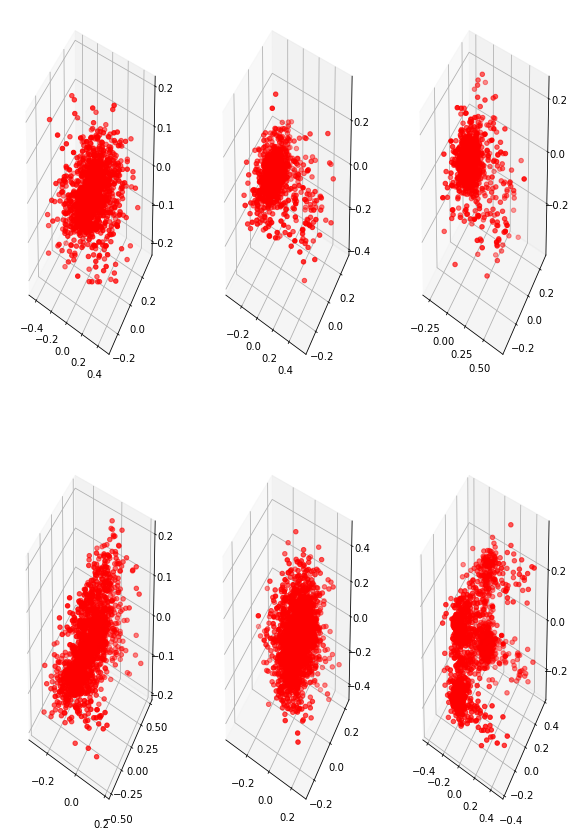

[('img/bed/0369.jpg', 'mask/bed/0369.png'),
 ('img/bed/0089.png', 'mask/bed/0089.png'),
 ('img/bed/0708.jpg', 'mask/bed/0708.png'),
 ('img/bed/0126.jpg', 'mask/bed/0126.png'),
 ('img/bed/0681.jpg', 'mask/bed/0681.png'),
 ('img/bed/0935.jpg', 'mask/bed/0935.png')]

In [164]:
# image_mask = zip(paths, mask_paths)
out = []

for image_path,mask_path  in image_mask:
#     image_path = paths[idx]
#     mask_path = mask_paths[idx]
    image = Image.open(image_path).convert('RGB')
    
#     print(image_path)
    
    mask = Image.open(mask_path)
    
#     plt.imshow(image)
    
    
    image = transform(image)
    mask = transform(mask)
    
    # Multiply
#     print(image.size(), mask.size())
    
    image = image* mask
#     break
    
    image = image.float().to(device=gpu_or_cpu)
    
    
    # Reshape to include batch size
    image = image.unsqueeze(0)
    
    
    pred = model(image)
    
    pred = pred.to('cpu')
    
    for p in pred:
        out.append(p.detach().numpy())
    
    if len(out) == 10:
        break
    
Visualize(out).ShowRandom()

image_mask[:6]

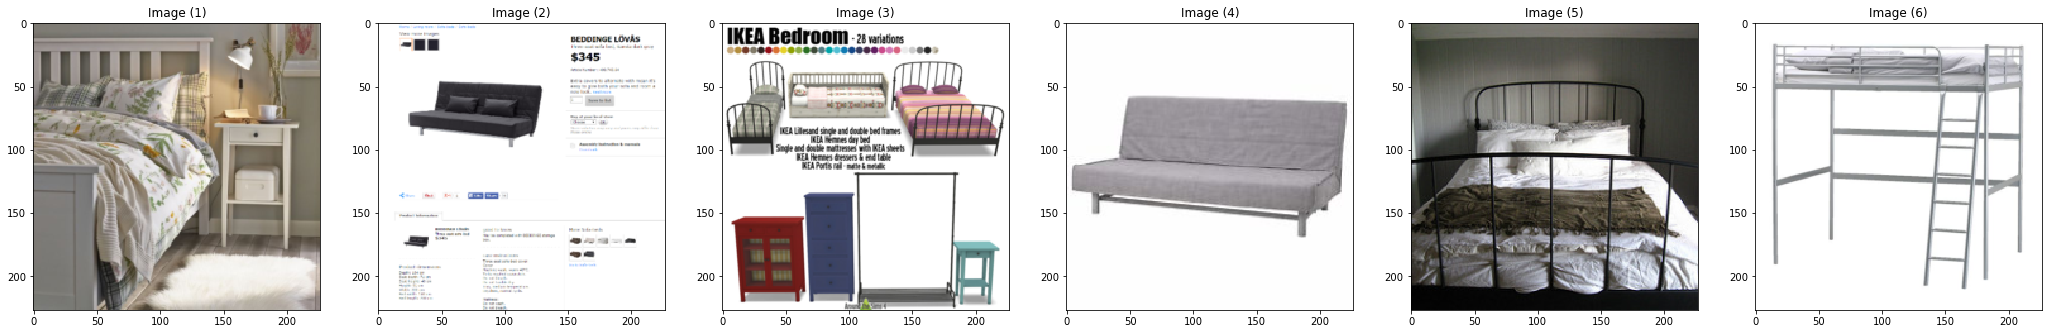

In [165]:
# fig = plt.figure(figsize = (10,15))

out_images = []

for image_path,mask_path  in image_mask[:6]:
#     print(image_path)
    image = Image.open(image_path).convert('RGB')
    mask = Image.open(mask_path)
    
    image = transform(image)

# To apply mask uncomment these two lines.    
#     mask = transform(mask)
#     image = image * mask

    image = np.array(image)
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    
#     print(image_path)
#     image = transform(image)
#     image = image.float().to('cpu').numpy()
    
    out_images.append(image)
    
    
#     plt.imshow(image)
    
show_images(out_images)

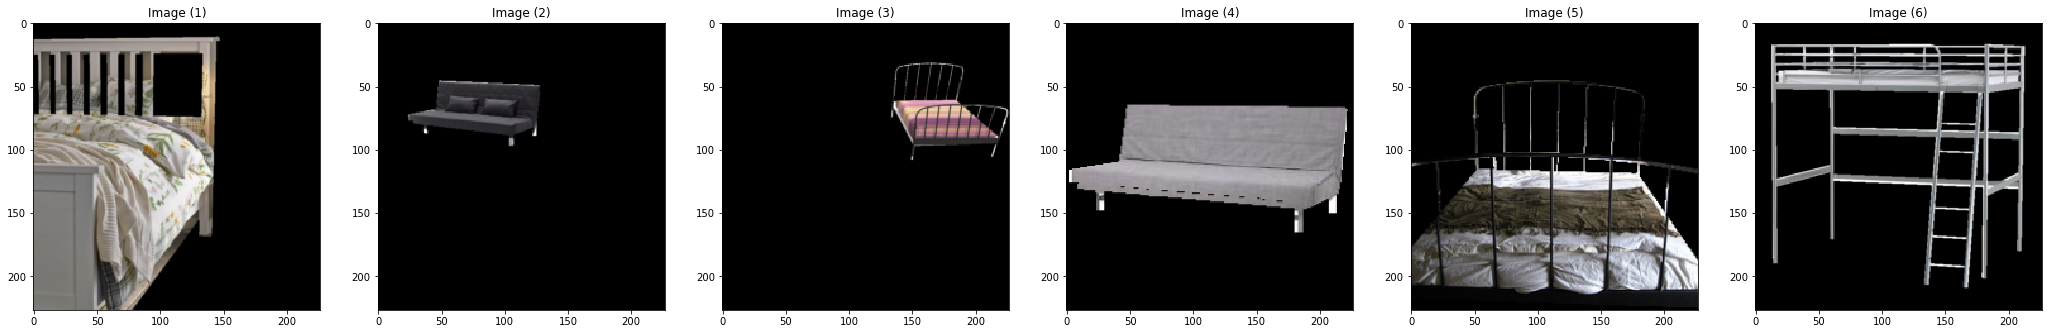

In [166]:
# fig = plt.figure(figsize = (10,15))

out_images = []

for image_path,mask_path  in image_mask[:6]:
#     print(image_path)
    image = Image.open(image_path).convert('RGB')
    mask = Image.open(mask_path)
    
    image = transform(image)

# To apply mask uncomment these two lines.    
    mask = transform(mask)
    image = image * mask

    image = np.array(image)
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    
#     print(image_path)
#     image = transform(image)
#     image = image.float().to('cpu').numpy()
    
    out_images.append(image)
    
    
#     plt.imshow(image)
    
show_images(out_images)